In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from matplotlib.colors import LinearSegmentedColormap

# Primary production analysis
From the labstaff, we've estimated how much primary production (PP) could occur in the ecosystem (with PSII) under saturating light conditions.We've used the maximum electron transport rate to derive how much carbon is fixed per unit time. 

In this notebook, we'll see if The resulting PP per sample is correlated with environmental variables.

In [33]:
# Data processing
## Read in primary production data
# Read updated LabSTAF data from both stations
PP_data_130 = pd.read_csv('../data/raw/LabSTAF/all_130_NF_final.csv', sep=';', decimal=',')
PP_data_51 = pd.read_csv('../data/raw/LabSTAF/all_051_NF_final.csv', sep=';', decimal=',')

# Combine datasets
PP_data = pd.concat([PP_data_130, PP_data_51], ignore_index=True)

# Convert datetime and calculate diel_index (mimicking R logic)
PP_data['datetime'] = pd.to_datetime(PP_data['datetime']) - pd.to_timedelta(1, unit='h')

# Add PPm column (same as PP = GOPIIm * 12)
PP_data['PPm'] = PP_data['GOPIIm'] * 12

# Extract relevant columns only
PPm_data = PP_data[['Note', 'PPm']].dropna()
# Ensure Note is string
PPm_data['Note'] = PPm_data['Note'].astype(str)
# Use regex to convert '130_01' → '130_1'
PPm_data['Station'] = PPm_data['Note'].str.replace(r'^0?(\d+)_0*([1-9]\d*)$', r'\1_\2', regex=True)

# Optional: Rename for consistency
PPm_data = PPm_data.rename(columns={'station': 'Station'})

env_data = pd.read_csv('../data/samples_env_carbon.csv')

## Read in flowcam data
flowcam_data = pd.read_csv('../data/analysis/flowcam_total_cell_density.csv')
## Rename columns
flowcam_data = flowcam_data.rename(columns={'sample':'Station'})

## Read in Transcript per L sums as an estimate of total biomass and/or activity
transcript_data = pd.read_csv('../data/analysis/tpl_sum.csv')
## Rename columns
transcript_data.columns = ['Station', 'TPL_sum']

## Read in Zooplankton counts
zooplankton_data = pd.read_csv('../data/analysis/zooplankton_counts.csv')

## Read in oxygen data
oxygen_51 = pd.read_csv('../data/analysis/O2_smoother_station_51.csv')
oxygen_130 = pd.read_csv('../data/analysis/O2_smoother_station_130.csv')
## Combine data
oxygen_data = pd.concat([oxygen_51, oxygen_130])

## Read in chlorophyll data
clorophyll_data = pd.read_csv('../data/samples_env_chlorophyll.csv')
## Keep only the columns of interest
clorophyll_data = clorophyll_data[['Station', 'Chl_a_zscore']]

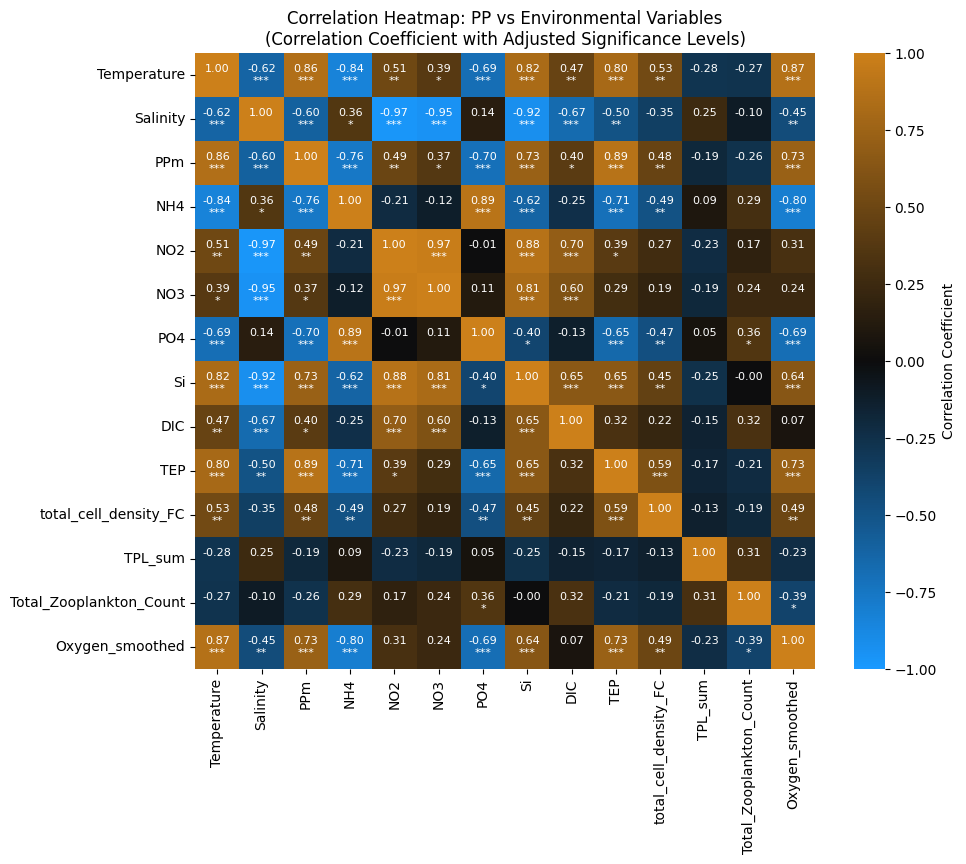

In [34]:
# Merge PP_data with env and transcript data
merged_data = pd.merge(PPm_data, env_data, on=['Station'], how='inner')
merged_data = pd.merge(merged_data, flowcam_data, on=['Station'], how='inner')
merged_data = pd.merge(merged_data, transcript_data, on=['Station'], how='inner')
merged_data = pd.merge(merged_data, zooplankton_data, on=['Station'], how='inner')
merged_data = pd.merge(merged_data, clorophyll_data, on=['Station'], how='inner')

# Ensure datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date']).dt.tz_localize(None)
oxygen_data['Date'] = pd.to_datetime(oxygen_data['Date'], format='mixed')

# Sort both dataframes by Date (required for merge_asof)
merged_data = merged_data.sort_values('Date')
oxygen_data = oxygen_data.sort_values('Date')

# Perform a nearest match (asof merge)
merged_data = pd.merge_asof(
    merged_data,
    oxygen_data[['Date', 'y']],
    on='Date',
    direction='nearest',
    tolerance=pd.Timedelta('30 minutes')
)

# Rename the matched column for clarity
merged_data = merged_data.rename(columns={'y': 'Oxygen_smoothed'})

# Declare variables of interest for correlation analysis
correlation_columns = [
    'Temperature', 'Salinity', 'PPm',
    'NH4', 'NO2', 'NO3', 'PO4', 'Si', 'DIC', 'TEP',
    'total_cell_density_FC', 'TPL_sum', 'Total_Zooplankton_Count', 
    'Oxygen_smoothed'
]
correlation_data = merged_data[correlation_columns].dropna()

# Calculate Pearson correlation coefficients
correlation_matrix = correlation_data.corr(method='pearson')

# Calculate p-values
p_values = np.zeros_like(correlation_matrix)
for i, col in enumerate(correlation_columns):
    for j in range(i, len(correlation_columns)):
        X = sm.add_constant(correlation_data[correlation_columns[j]])  # Add constant
        model = sm.OLS(correlation_data[col], X).fit()  # Fit the linear model relating the two variables, col and correlation_columns[j] with constant
        p_values[i, j] = p_values[j, i] = model.pvalues.iloc[1]  # Store p-values

# Adjust p-values for multiple testing using the Benjamini-Hochberg method
p_values_flat = p_values[np.triu_indices_from(p_values, k=1)]  # Extract upper triangle p-values
adjusted_p_values_flat = multipletests(p_values_flat, method='fdr_bh')[1]  # Adjust using Benjamini-Hochberg
adjusted_p_values = np.zeros_like(p_values)
adjusted_p_values[np.triu_indices_from(p_values, k=1)] = adjusted_p_values_flat
adjusted_p_values += adjusted_p_values.T  # Mirror the upper triangle to the lower triangle

# Create custom annotations for the heatmap
annotations = np.empty_like(correlation_matrix).astype(str)
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        # Format correlation value
        corr_value = f'{correlation_matrix.iloc[i, j]:.2f}'
        
        # Determine significance level, ignoring the diagonal
        if i != j:
            if adjusted_p_values[i, j] < 0.001:
                significance = '***'
            elif adjusted_p_values[i, j] < 0.01:
                significance = '**'
            elif adjusted_p_values[i, j] < 0.05:
                significance = '*'
            else:
                significance = ''
        else:
            significance = ''  # No significance flag for diagonal
        
        # Combine correlation value with significance level
        annotations[i, j] = f'{corr_value}\n{significance}'

# Plot the heatmap
## Define custom colormap
clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
cmap = LinearSegmentedColormap.from_list("cmap_name", clist)
## Plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=annotations,
            fmt='', cmap=cmap,
            vmin=-1, 
            vmax=1, 
            cbar_kws={'label': 'Correlation Coefficient'},
            annot_kws={'fontsize': 8})
plt.title('Correlation Heatmap: PP vs Environmental Variables\n(Correlation Coefficient with Adjusted Significance Levels)')
## Save the plot
plt.savefig('../figures/correlation_heatmap.png', bbox_inches='tight', dpi=800)
plt.savefig('../figures/correlation_heatmap.svg', bbox_inches='tight', dpi=800)
plt.show()

<Figure size 1100x800 with 0 Axes>

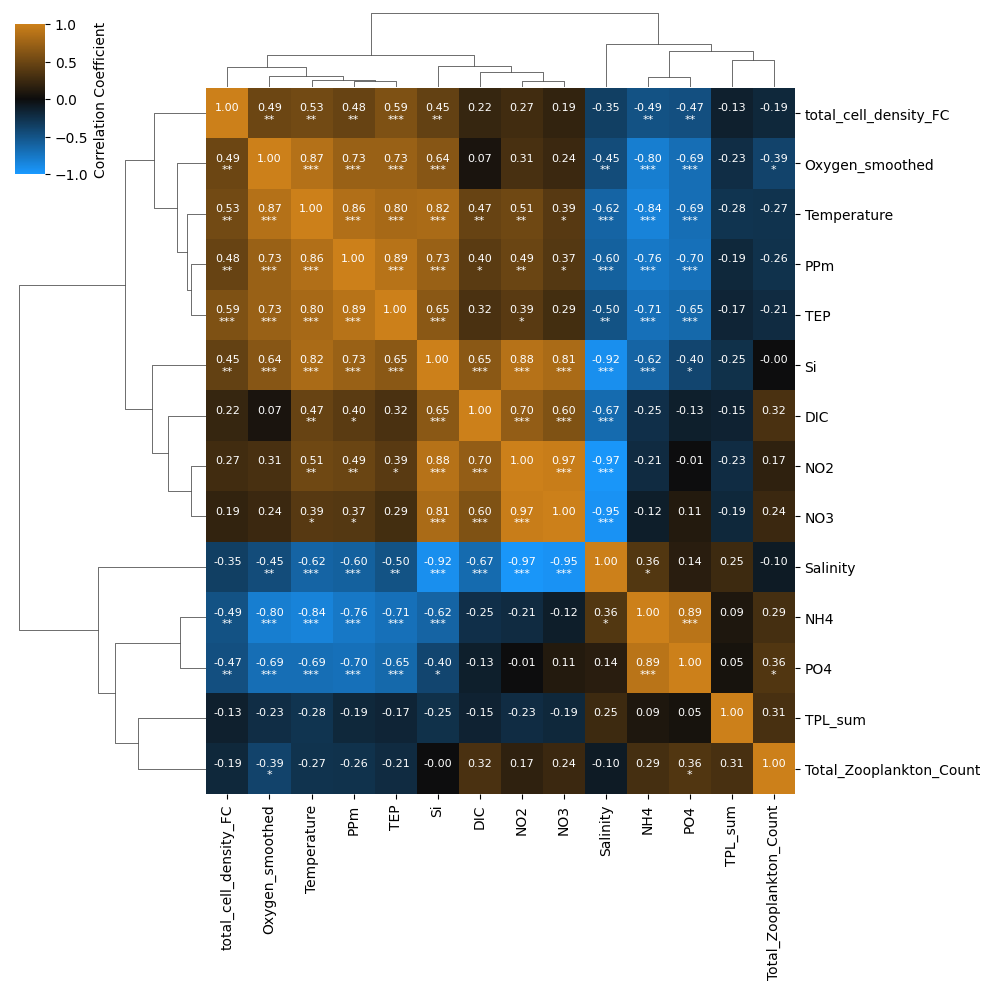

In [35]:
# Plot the clustermap
## Plot with the legend on the bottom right
plt.figure(figsize=(11, 8))
sns.clustermap(correlation_matrix,
               annot=annotations, fmt='',
               cmap=cmap,
               vmin=-1,
               vmax=1,
               cbar_kws={'label': 'Correlation Coefficient',
                         'shrink': 0.33},
               annot_kws={'fontsize': 8},
               row_cluster=True,
               col_cluster=True,
               dendrogram_ratio=(0.25, 0.1),
               cbar_pos=(0.02, 0.82, 0.03, 0.15))

## Save the plot
plt.savefig('../figures/correlation_clustermap.png', bbox_inches='tight', dpi=800)
plt.savefig('../figures/correlation_clustermap.svg', bbox_inches='tight', dpi=800)
plt.show()

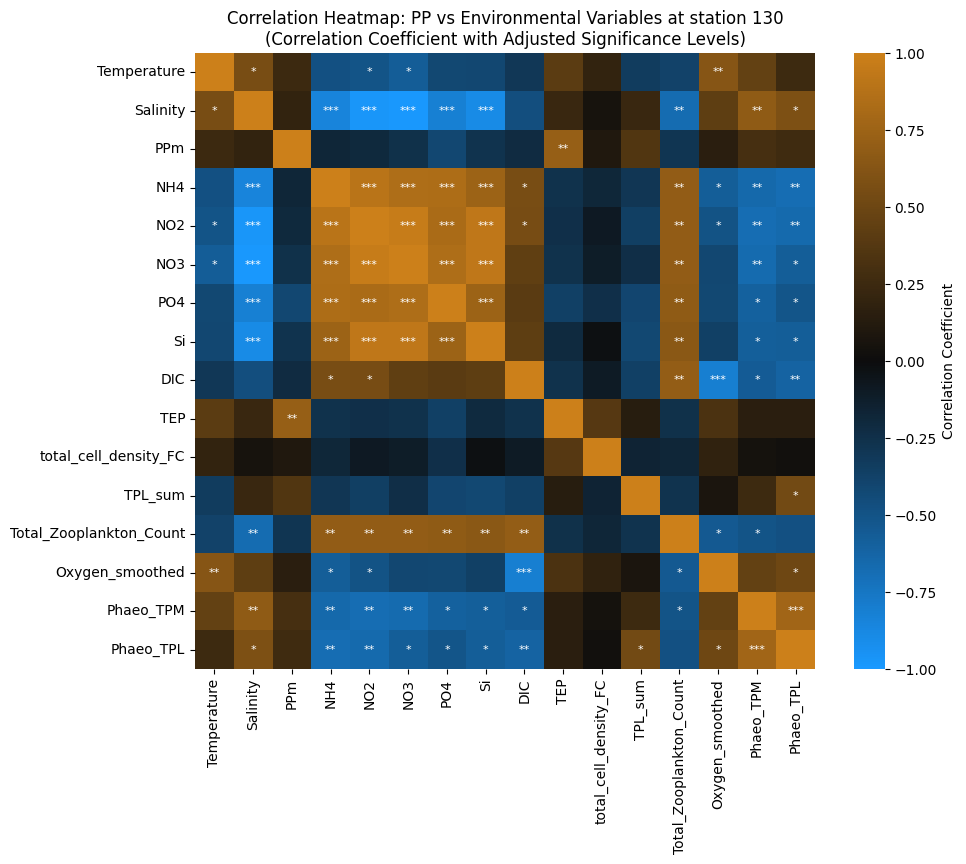

In [36]:
# Re-do for station 130 only
# Filter data for Station 130
station_130_data = merged_data[merged_data['StationPrefix'] == 130]
## Add Phaeocystis TPM/TPL sums to the correlation_columns
phaeo_TPM = pd.read_csv('../data/analysis/phaeocystis_bin_tpm_130.csv')
phaeo_TPM.columns = ['Station', 'Phaeo_TPM']
phaeo_TPL = pd.read_csv('../data/analysis/phaeocystis_bin_tpl_130.csv')
phaeo_TPL.columns = ['Station', 'Phaeo_TPL']
station_130_data = pd.merge(station_130_data, phaeo_TPM, on='Station', how='inner')
station_130_data = pd.merge(station_130_data, phaeo_TPL, on='Station', how='inner')

# Add Phaeocystis TPM/TPL sums to the correlation_columns
correlation_columns_130 = [
    'Temperature', 'Salinity', 'PPm',
    'NH4', 'NO2', 'NO3', 'PO4', 'Si', 'DIC', 'TEP',
    'total_cell_density_FC', 'TPL_sum', 'Total_Zooplankton_Count', 
    'Oxygen_smoothed', 'Phaeo_TPM', 'Phaeo_TPL']
correlation_data = station_130_data[correlation_columns_130].dropna()

# Calculate Pearson correlation coefficients
correlation_matrix = correlation_data.corr(method='pearson')

# Calculate p-values
p_values = np.zeros_like(correlation_matrix)
for i, col in enumerate(correlation_columns_130):
    for j in range(i, len(correlation_columns_130)):
        X = sm.add_constant(correlation_data[correlation_columns_130[j]])  # Add constant
        model = sm.OLS(correlation_data[col], X).fit()  # Fit the linear model relating the two variables, col and correlation_columns[j] with constant
        p_values[i, j] = p_values[j, i] = model.pvalues.iloc[1]  # Store p-values

# Adjust p-values for multiple testing using the Benjamini-Hochberg method
p_values_flat = p_values[np.triu_indices_from(p_values, k=1)]  # Extract upper triangle p-values
adjusted_p_values_flat = multipletests(p_values_flat, method='fdr_bh')[1]  # Adjust using Benjamini-Hochberg
adjusted_p_values = np.zeros_like(p_values)
adjusted_p_values[np.triu_indices_from(p_values, k=1)] = adjusted_p_values_flat
adjusted_p_values += adjusted_p_values.T  # Mirror the upper triangle to the lower triangle

# Create custom annotations for the heatmap
annotations = np.empty_like(correlation_matrix).astype(str)
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        # Determine significance level, ignoring the diagonal
        if i != j:
            if adjusted_p_values[i, j] < 0.001:
                significance = '***'
            elif adjusted_p_values[i, j] < 0.01:
                significance = '**'
            elif adjusted_p_values[i, j] < 0.05:
                significance = '*'
            else:
                significance = ''
        else:
            significance = ''  # No significance flag for diagonal
        
        # Combine correlation value with significance level
        annotations[i, j] = f'{significance}'

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=annotations,
            fmt='', cmap=cmap,
            vmin=-1, 
            vmax=1, 
            cbar_kws={'label': 'Correlation Coefficient'},
            annot_kws={'fontsize': 8})
plt.title('Correlation Heatmap: PP vs Environmental Variables at station 130\n(Correlation Coefficient with Adjusted Significance Levels)')
## Save the plot
plt.savefig('../figures/correlation_heatmap_130.png', bbox_inches='tight', dpi=800)
plt.savefig('../figures/correlation_heatmap_130.svg', bbox_inches='tight', dpi=800)
plt.show()

<Figure size 1100x800 with 0 Axes>

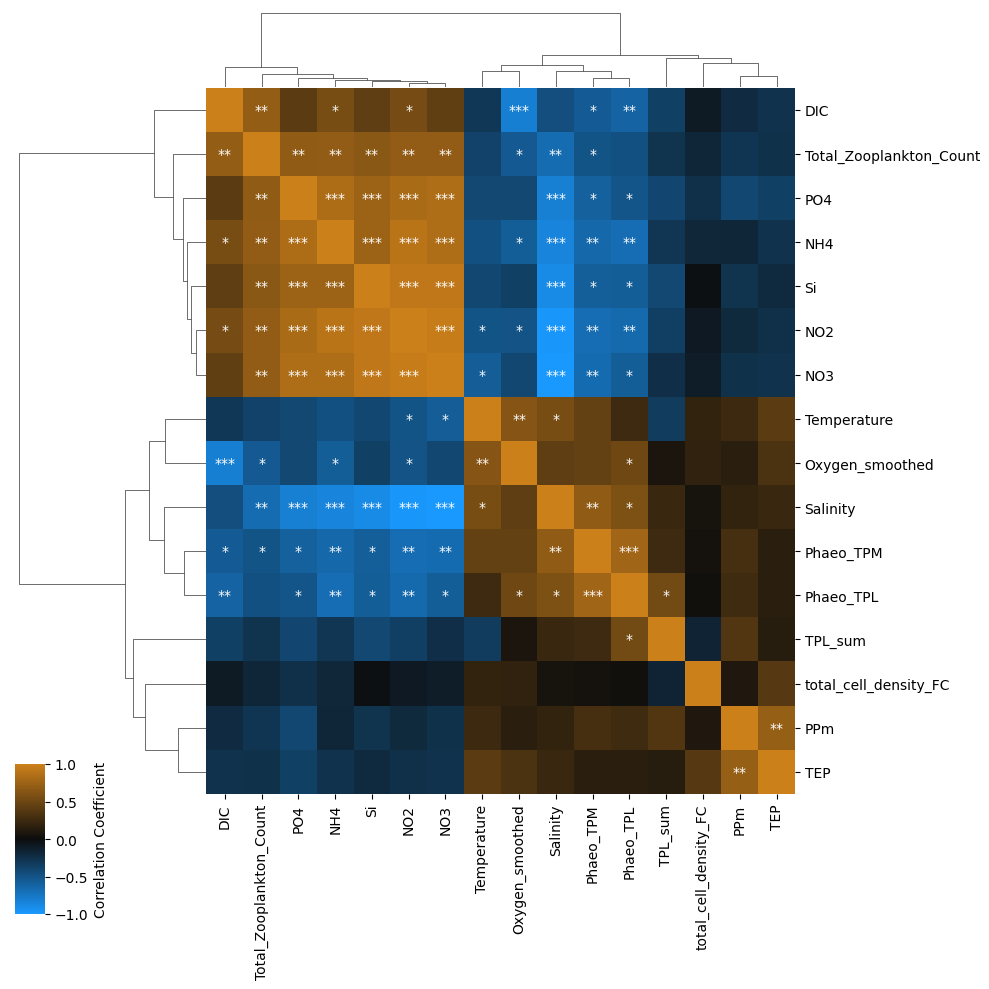

In [37]:
# Plot the clustermap
## Plot with the legend on the bottom right
plt.figure(figsize=(11, 8))
sns.clustermap(correlation_matrix,
               annot=annotations, fmt='',
               cmap=cmap,
               vmin=-1,
               vmax=1,
               cbar_kws={'label': 'Correlation Coefficient',
                         'shrink': 0.33},
               annot_kws={'fontsize': 10},
               row_cluster=True,
               col_cluster=True,
               dendrogram_ratio=(0.25, 0.1),
               cbar_pos=(0.02, 0.08, 0.03, 0.15))
## Save the plot
plt.savefig('../figures/correlation_clustermap_130.png', bbox_inches='tight', dpi=800)
plt.savefig('../figures/correlation_clustermap_130.svg', bbox_inches='tight', dpi=800)
plt.show()

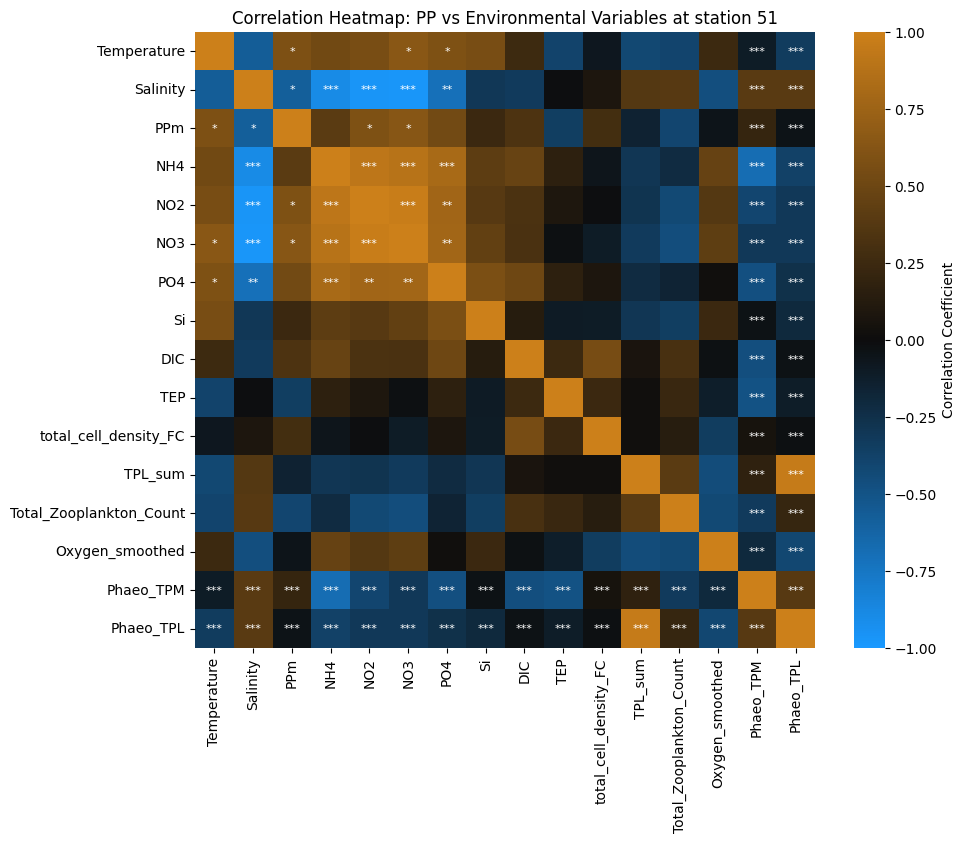

In [38]:
# Re-do for station 51
# Filter data for Station 51
station_51_data = merged_data[merged_data['StationPrefix'] == 51]
## Add Phaeocystis TPM/TPL sums to the correlation_columns
phaeo_TPM = pd.read_csv('../data/analysis/phaeocystis_bin_tpm_51.csv')
phaeo_TPM.columns = ['Station', 'Phaeo_TPM']
phaeo_TPL = pd.read_csv('../data/analysis/phaeocystis_bin_tpl_51.csv')
phaeo_TPL.columns = ['Station', 'Phaeo_TPL']
station_51_data = pd.merge(station_51_data, phaeo_TPM, on='Station', how='inner')
station_51_data = pd.merge(station_51_data, phaeo_TPL, on='Station', how='inner')

# Add Phaeocystis TPM/TPL sums to the correlation_columns
correlation_data = station_51_data[correlation_columns_130].dropna()

# Calculate Pearson correlation coefficients
correlation_matrix = correlation_data.corr(method='pearson')

# Calculate p-values
p_values = np.zeros_like(correlation_matrix)
for i, col in enumerate(correlation_columns):
    for j in range(i, len(correlation_columns)):
        X = sm.add_constant(correlation_data[correlation_columns[j]])  # Add constant
        model = sm.OLS(correlation_data[col], X).fit()  # Fit the linear model relating the two variables, col and correlation_columns[j] with constant
        p_values[i, j] = p_values[j, i] = model.pvalues.iloc[1]  # Store p-values

# Adjust p-values for multiple testing using the Benjamini-Hochberg method
p_values_flat = p_values[np.triu_indices_from(p_values, k=1)]  # Extract upper triangle p-values
adjusted_p_values_flat = multipletests(p_values_flat, method='fdr_bh')[1]  # Adjust using Benjamini-Hochberg
adjusted_p_values = np.zeros_like(p_values)
adjusted_p_values[np.triu_indices_from(p_values, k=1)] = adjusted_p_values_flat
adjusted_p_values += adjusted_p_values.T  # Mirror the upper triangle to the lower triangle

# Create custom annotations for the heatmap
annotations = np.empty_like(correlation_matrix).astype(str)
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        # Determine significance level, ignoring the diagonal
        if i != j:
            if adjusted_p_values[i, j] < 0.001:
                significance = '***'
            elif adjusted_p_values[i, j] < 0.01:
                significance = '**'
            elif adjusted_p_values[i, j] < 0.05:
                significance = '*'
            else:
                significance = ''
        else:
            significance = ''  # No significance flag for diagonal
        
        # Combine correlation value with significance level
        annotations[i, j] = f'{significance}'

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=annotations,
            fmt='', cmap=cmap,
            vmin=-1, 
            vmax=1, 
            cbar_kws={'label': 'Correlation Coefficient'},
            annot_kws={'fontsize': 8})
plt.title('Correlation Heatmap: PP vs Environmental Variables at station 51')
# Save the plot
plt.savefig('../figures/correlation_heatmap_51.png', bbox_inches='tight', dpi=800)
plt.savefig('../figures/correlation_heatmap_51.svg', bbox_inches='tight', dpi=800)
plt.show()

<Figure size 1100x800 with 0 Axes>

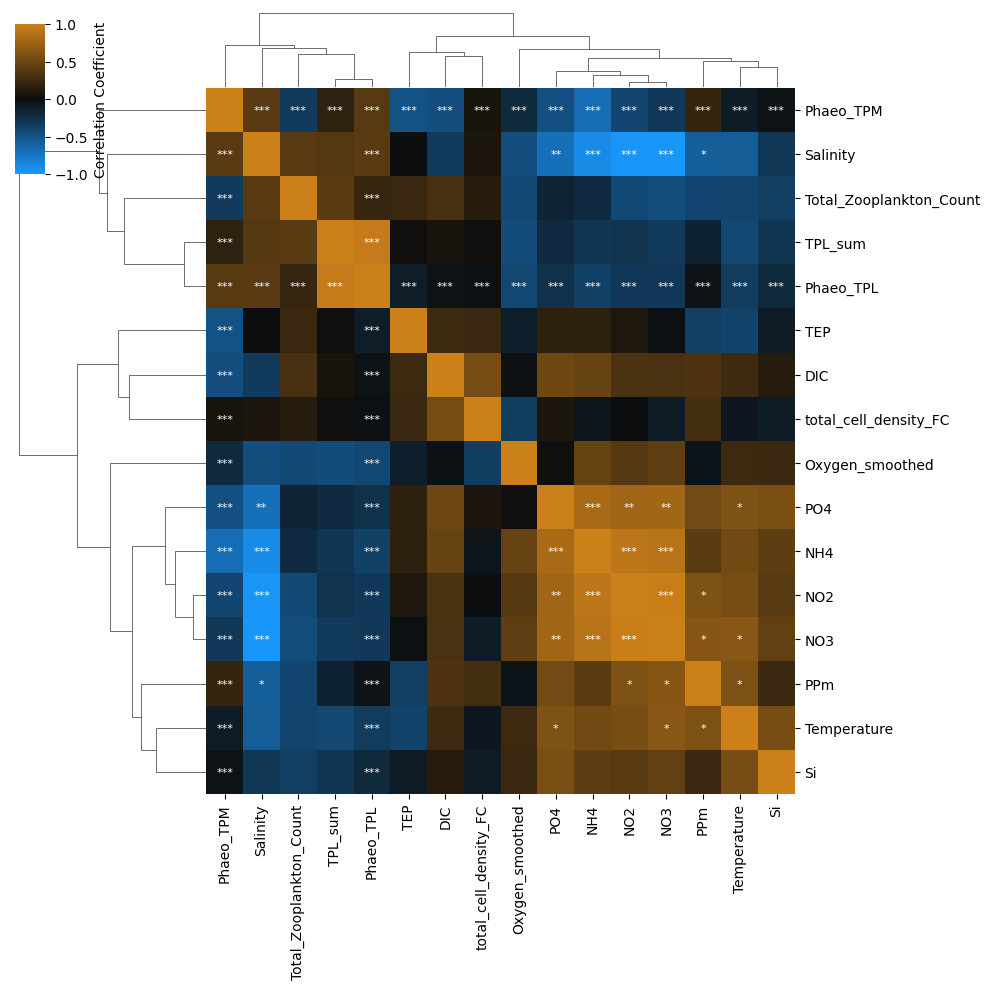

In [39]:
# Plot the clustermap
## Plot with the legend on the bottom right
plt.figure(figsize=(11, 8))
sns.clustermap(correlation_matrix,
               annot=annotations, fmt='',
               cmap=cmap,
               vmin=-1,
               vmax=1,
               cbar_kws={'label': 'Correlation Coefficient',
                         'shrink': 0.33},
               annot_kws={'fontsize': 8},
               row_cluster=True,
               col_cluster=True,
               dendrogram_ratio=(0.25, 0.1),
               cbar_pos=(0.02, 0.82, 0.03, 0.15))
## Save the plot
plt.savefig('../figures/correlation_clustermap_51.png', bbox_inches='tight', dpi=800)
plt.savefig('../figures/correlation_clustermap_51.svg', bbox_inches='tight', dpi=800)
plt.show()

In [40]:
# Re-do the clustermap comparing both stations, but add Phaeo_TPM and Phaeo_TPL to the correlation_columns
# Add Phaeocystis TPM/TPL sums to the correlation_columns for both stations
phaeo_TPM_130 = pd.read_csv('../data/analysis/phaeocystis_bin_tpm_130.csv')
phaeo_TPM_130.columns = ['Station', 'Phaeo_TPM']
phaeo_TPL_130 = pd.read_csv('../data/analysis/phaeocystis_bin_tpl_130.csv')
phaeo_TPL_130.columns = ['Station', 'Phaeo_TPL']

phaeo_TPM_51 = pd.read_csv('../data/analysis/phaeocystis_bin_tpm_51.csv')
phaeo_TPM_51.columns = ['Station', 'Phaeo_TPM']
phaeo_TPL_51 = pd.read_csv('../data/analysis/phaeocystis_bin_tpl_51.csv')
phaeo_TPL_51.columns = ['Station', 'Phaeo_TPL']

# Combine the data for both stations into a single dataframe
phaeo_TPM_combined = pd.concat([phaeo_TPM_130, phaeo_TPM_51], ignore_index=True)
phaeo_TPL_combined = pd.concat([phaeo_TPL_130, phaeo_TPL_51], ignore_index=True)

## Combine data
merged_data = pd.merge(merged_data, phaeo_TPM_combined, on='Station', how='inner')
merged_data = pd.merge(merged_data, phaeo_TPL_combined, on='Station', how='inner')

correlation_data = merged_data[correlation_columns_130].dropna()

# Calculate Pearson correlation coefficients
correlation_matrix = correlation_data.corr(method='pearson')

# Calculate p-values
p_values = np.zeros_like(correlation_matrix)
for i, col in enumerate(correlation_columns):
    for j in range(i, len(correlation_columns)):
        X = sm.add_constant(correlation_data[correlation_columns[j]])  # Add constant
        model = sm.OLS(correlation_data[col], X).fit()  # Fit the linear model relating the two variables, col and correlation_columns[j] with constant
        p_values[i, j] = p_values[j, i] = model.pvalues.iloc[1]  # Store p-values

# Adjust p-values for multiple testing using the Benjamini-Hochberg method
p_values_flat = p_values[np.triu_indices_from(p_values, k=1)]  # Extract upper triangle p-values
adjusted_p_values_flat = multipletests(p_values_flat, method='fdr_bh')[1]  # Adjust using Benjamini-Hochberg
adjusted_p_values = np.zeros_like(p_values)
adjusted_p_values[np.triu_indices_from(p_values, k=1)] = adjusted_p_values_flat
adjusted_p_values += adjusted_p_values.T  # Mirror the upper triangle to the lower triangle

# Create custom annotations for the heatmap
annotations = np.empty_like(correlation_matrix).astype(str)
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        # Determine significance level, ignoring the diagonal
        if i != j:
            if adjusted_p_values[i, j] < 0.001:
                significance = '***'
            elif adjusted_p_values[i, j] < 0.01:
                significance = '**'
            elif adjusted_p_values[i, j] < 0.05:
                significance = '*'
            else:
                significance = ''
        else:
            significance = ''  # No significance flag for diagonal
        
        # Combine correlation value with significance level
        annotations[i, j] = f'{significance}'

<Figure size 1100x800 with 0 Axes>

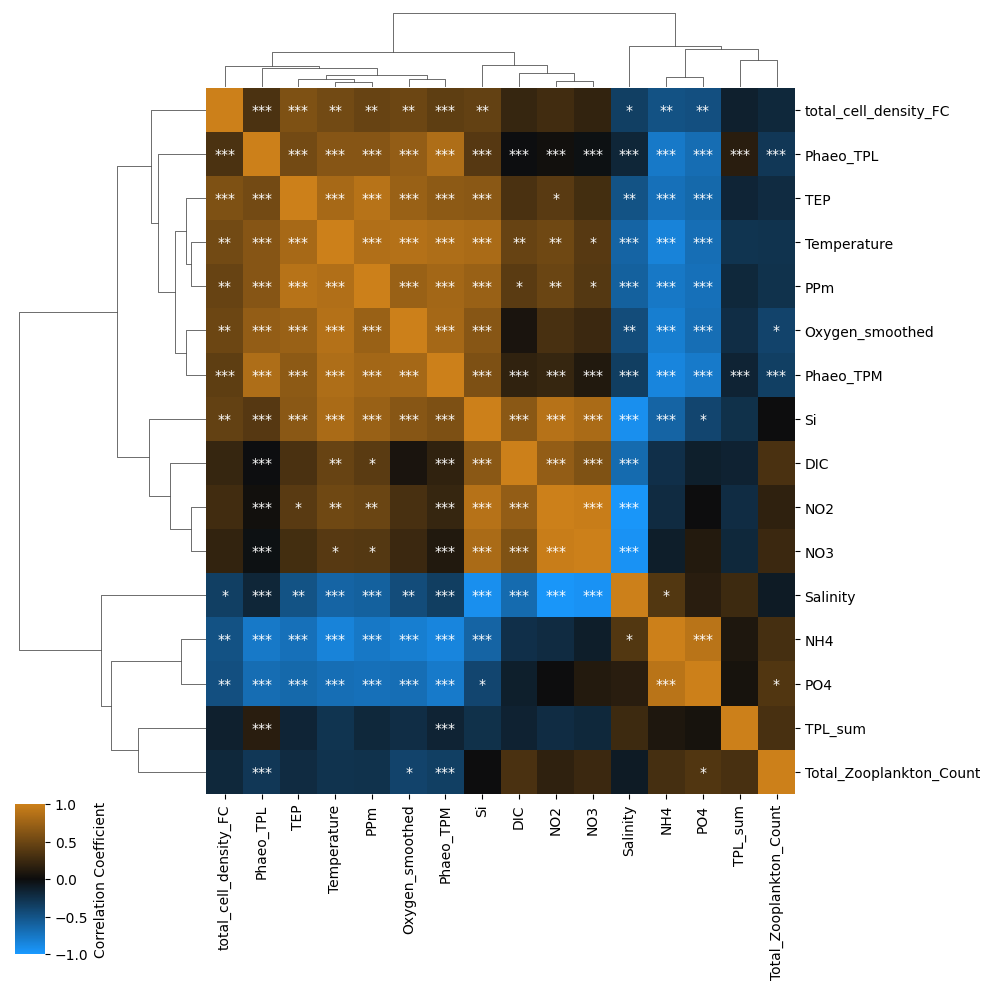

In [43]:
# Plot the clustermap
## Plot with the legend on the bottom right
plt.figure(figsize=(11, 8))
sns.clustermap(correlation_matrix,
               annot=annotations, fmt='',
               cmap=cmap,
               vmin=-1,
               vmax=1,
               cbar_kws={'label': 'Correlation Coefficient',
                         'shrink': 0.33},
               annot_kws={'fontsize': 10},
               row_cluster=True,
               col_cluster=True,
               dendrogram_ratio=(0.25, 0.1),
               cbar_pos=(0.02, 0.04, 0.03, 0.15))
## Save the plot
plt.savefig('../figures/correlation_clustermap_Phaeo.png', bbox_inches='tight', dpi=800)
plt.savefig('../figures/correlation_clustermap_Phaeo.svg', bbox_inches='tight', dpi=800)
plt.show()